[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
else:
    dataset_path = 'data'

In [2]:
import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pycocotools.coco import COCO
import fiftyone as fo
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import cv2

## Обучение модели

In [3]:
import os
import json
#import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pycocotools.coco import COCO
import fiftyone as fo
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import cv2
#PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

In [4]:
#from PIL import Image
#img = Image.open('data/rtsd-frames/autosave01_02_2012_09_16_49.jpg').convert("RGB")
#img

### Загрузчик данных

In [4]:
# Преобразование классов знаков в 1 класс
def anno_to_bin_class(anno_file):
    '''Функция создает копию файла с аннотацией, преобразует все классы в 1 (знак)
    и сохраняет новый файл с аннотацией'''
    with open(os.path.join(dataset_path, anno_file), 'r') as read_file:
        anno_json = json.load(read_file)
    read_file.close()

    for i in range(len(anno_json['annotations'])):
        anno_json['annotations'][i]['category_id'] = 1    
    
    anno_json['categories'] = [{'id': 1, 'name': 'sign'}]
    
    anno_file_new = anno_file.split('.')[0] + '_bin_class.json'
    
    with open(os.path.join(dataset_path, anno_file_new), 'w') as f:
        json.dump(anno_json, f)#ensure_ascii=False, indent=4)
    f.close()

    return anno_json
anno_to_bin_class('train_anno.json')
anno_to_bin_class('train_anno_reduced.json')
anno_to_bin_class('val_anno.json')


{'images': [{'id': 22978,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave10_10_2012_13_50_36_1.jpg'},
  {'id': 53820,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave24_10_2012_10_20_51_2.jpg'},
  {'id': 52206,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave23_10_2012_14_41_26_0.jpg'},
  {'id': 48186,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave23_10_2012_10_16_35_2.jpg'},
  {'id': 41953,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave16_10_2012_11_44_25_2.jpg'},
  {'id': 38421,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave16_10_2012_08_45_17_4.jpg'},
  {'id': 27187,
   'width': 1920,
   'height': 1080,
   'file_name': 'rtsd-frames/autosave13_04_2013_13_38_32_1.jpg'},
  {'id': 19104,
   'width': 1280,
   'height': 720,
   'file_name': 'rtsd-frames/autosave10_10_2012_10_00_59_0.jpg'},
  {'id': 58486,
   'width': 1280,
   'height'

In [5]:
with open(os.path.join(dataset_path, 'train_anno_bin_class.json'), 'r') as read_file:
    temp = json.load(read_file)
read_file.close()
len(temp.get('images'))

54188

In [6]:
train_anno_coco = COCO(os.path.join(dataset_path, 'train_anno_bin_class.json'))

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


In [8]:
# получение идентификатора категории
train_anno_coco.getCatIds(['sign'])

[1]

In [9]:
# получение ID аннотации для указанного ID изображения
annotation_ids = train_anno_coco.getAnnIds(imgIds=95)
annotation_ids

[175, 176, 177]

In [10]:
# получение ID изображений, содержащих объект с указанным ID
len(train_anno_coco.getImgIds(catIds=[1]))

54188

In [11]:
# получение ID аннотации для указанных ID изображения и ID категории
annotation_ids = train_anno_coco.getAnnIds(imgIds=95, catIds=[1])
annotation_ids

[175, 176, 177]

In [12]:
def pycocotools_visualizer(image_id, category_id = None):
    '''функция по выводу изображения с указанным ID
    и визуализацией аннотаций с выбранными ID категорий (список)
    Если ID категорий не указаны - выводятся все аннотации для изображения'''
    if category_id:
        annotation_ids = train_anno_coco.getAnnIds(imgIds=image_id, catIds=category_id)
    else:
        annotation_ids = train_anno_coco.getAnnIds(imgIds=image_id)
            
    # загрузка аннотаций в список
    anns = train_anno_coco.loadAnns(annotation_ids)

    # путь к изображению и его название
    images_path = dataset_path
    image_name = train_anno_coco.imgs.get(image_id).get('file_name')
    image = Image.open(os.path.join(images_path, image_name))
    
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    
    # Draw boxes and add label to each box
    for ann in anns:
        box = ann['bbox']
        bb = patches.Rectangle((box[0],box[1]), box[2],box[3], linewidth=1, edgecolor="yellow", facecolor="none")
        ax.add_patch(bb)
    
    ax.imshow(image)
    plt.show()

In [13]:
pycocotools_visualizer(95, [1])

C:\Users\User\AppData\Local\Temp\ipykernel_10792\4181196525.py:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [14]:
# загрузка датасета

# The directiry containing the source images
data_path = dataset_path      # можно не указывать, если в JSON путь совпадает

# The path yo the COCO labels JSON file
labels_file = "train_anno_bin_class.json"
labels_path = os.path.join(dataset_path, labels_file)


# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path
)

 100% |█████████████| 54188/54188 [1.4m elapsed, 0s remaining, 687.1 samples/s]      


In [15]:
# Визуализация набора данных
session = fo.launch_app(dataset)

In [16]:
# Использование агрегатов с помощью API для получения статистики о наборе данных
# Количество обнаружений для каждой категории
dataset.count_values("detections.detections.label")

{'sign': 95492}

In [2]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
else:
    dataset_path = 'data'

In [3]:
import os
import json
#import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pycocotools.coco import COCO
import fiftyone as fo
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import cv2
#PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

In [4]:
class RTSD_dataset(Dataset):
  
    def __init__(self, json_path, img_path):
        self.json_path = json_path
        self.img_path = img_path
        
        with open(json_path, 'r') as read_file:
            self.anno = json.load(read_file)
        read_file.close()

        self.df_dataset = pd.DataFrame(self.anno.get('annotations'))
        self.test = self.df_dataset.copy()
        #self.test['bbox_for_rcnn'] = self.test.bbox[0]
        self.df_images = pd.DataFrame(self.anno.get('images'))
        self.df_images.rename(columns={'id':'image_id'}, inplace=True)
        self.df_dataset = self.df_dataset.merge(self.df_images)
        self.df_dataset = self.df_dataset[['file_name', 'bbox', 'category_id']].groupby('file_name', as_index=False).agg(list)

    def get_df(self):
        #return self.df_dataset
        return self.test

    def __len__(self):
        return self.df_dataset.shape[0]
  
    def __getitem__(self, index):
        img_name = self.df_dataset.loc[index,'file_name']
        boxes = []
        for box in self.df_dataset.loc[index,'bbox']:
            box_for_rcnn = [box[0], box[1], box[0] + box[2], box[1] + box[3]]
        boxes.append(box_for_rcnn)
        boxes = torch.Tensor(boxes).to(torch.float)            # возможно нужно преобразовать x_max и y_max
        #boxes = torch.Tensor(self.df_dataset.loc[index, 'bbox']).to(torch.float)
        labels = torch.Tensor(self.df_dataset.loc[index, 'category_id']).to(torch.int64)
        #area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        #iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        img = cv2.imread(os.path.join(self.img_path, img_name))/255.
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        #return img, target
        return img, target

In [8]:
#test = RTSD_dataset('data/train_anno_reduced.json', 'data/')
#test.__getitem__(0)

### Формирование батча

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

### Гиперпараметры

In [6]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'
n_epochs = 10
batch_size = 8
num_classes = 2

In [11]:
device

'cuda:0'

### Инициализация модели, задание оптимизатора и функции потерь

In [7]:
def create_model(num_classes, pretrained=True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [8]:
model = create_model(num_classes=2, pretrained=True).to(device)




# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

#params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)



#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno_bin_class.json'),
                                          dataset_path)
val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno_bin_class.json'), dataset_path)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

### Трейн луп

In [9]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [21]:
train_losses = []
val_losses = []
try:
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        '''torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_{epoch}.pth'))'''
    
except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 0. Итерация 0/6774. Loss: 0.14516153931617737
	Эпоха 0. Итерация 50/6774. Loss: 0.12067607045173645
	Эпоха 0. Итерация 100/6774. Loss: 0.08871646970510483
	Эпоха 0. Итерация 150/6774. Loss: 0.07951545715332031
	Эпоха 0. Итерация 200/6774. Loss: 0.08386529237031937
	Эпоха 0. Итерация 250/6774. Loss: 0.07034370303153992
	Эпоха 0. Итерация 300/6774. Loss: 0.07119864225387573
	Эпоха 0. Итерация 350/6774. Loss: 0.09133509546518326
	Эпоха 0. Итерация 400/6774. Loss: 0.07764226198196411
	Эпоха 0. Итерация 450/6774. Loss: 0.0889781266450882
	Эпоха 0. Итерация 500/6774. Loss: 0.07911151647567749
	Эпоха 0. Итерация 550/6774. Loss: 0.13165231049060822
	Эпоха 0. Итерация 600/6774. Loss: 0.10267668217420578
	Эпоха 0. Итерация 650/6774. Loss: 0.06235622614622116
	Эпоха 0. Итерация 700/6774. Loss: 0.07396701723337173
	Эпоха 0. Итерация 750/6774. Loss: 0.09777706116437912
	Эпоха 0. Итерация 800/6774. Loss: 0.12169838696718216
	Эпоха 0. Итерация 850/6774. Loss: 0.055699270218610764
	Эпоха 0. Ите

In [23]:
#torch.save(model, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_full.pth'))

In [51]:
'''torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'losses_train': train_losses,
    'losses_val': val_losses
    }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_{epoch}.pth'))'''

In [7]:
def create_model(num_classes, pretrained=True):
    model =torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [8]:
model = create_model(num_classes=2, pretrained=True).to(device)




# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

#params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)



#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno_bin_class.json'),
                                          dataset_path)
val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno_bin_class.json'), dataset_path)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

In [9]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    #model.eval()
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [10]:
train_losses = []
val_losses = []
try:
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_v2_{epoch}.pth'))
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'losses_train': train_losses,
    'losses_val': val_losses
    }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_v2_full.pth'))
except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 0. Итерация 0/6774. Loss: 1.0382219552993774
	Эпоха 0. Итерация 50/6774. Loss: 0.11720094084739685
	Эпоха 0. Итерация 100/6774. Loss: 0.06068731099367142
	Эпоха 0. Итерация 150/6774. Loss: 0.10895299166440964
	Эпоха 0. Итерация 200/6774. Loss: 0.073063425719738
	Эпоха 0. Итерация 250/6774. Loss: 0.06675528734922409
	Эпоха 0. Итерация 300/6774. Loss: 0.05316562205553055
	Эпоха 0. Итерация 350/6774. Loss: 0.06849160045385361
	Эпоха 0. Итерация 400/6774. Loss: 0.09670431166887283
	Эпоха 0. Итерация 450/6774. Loss: 0.07279185950756073
	Эпоха 0. Итерация 500/6774. Loss: 0.06095324829220772
	Эпоха 0. Итерация 550/6774. Loss: 0.09632769227027893
	Эпоха 0. Итерация 600/6774. Loss: 0.06296426802873611
	Эпоха 0. Итерация 650/6774. Loss: 0.06337529420852661
	Эпоха 0. Итерация 700/6774. Loss: 0.055704277008771896
	Эпоха 0. Итерация 750/6774. Loss: 0.05620956048369408
	Эпоха 0. Итерация 800/6774. Loss: 0.05700146406888962
	Эпоха 0. Итерация 850/6774. Loss: 0.05428871139883995
	Эпоха 0. Итера

In [12]:
def create_model(num_classes, pretrained=True):
    model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [13]:
model = create_model(num_classes=2, pretrained=True).to(device)




# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

#params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)



#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno_bin_class.json'),
                                          dataset_path)
val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno_bin_class.json'), dataset_path)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to C:\Users\User/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [14]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [15]:
train_losses = []
val_losses = []
try:
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(dataset_path, f'../checkpoints/model_detector_mobilenet_v3_large_fpn_{epoch}.pth'))
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'losses_train': train_losses,
    'losses_val': val_losses
    }, os.path.join(dataset_path, f'../checkpoints/model_detector_mobilenet_v3_large_fpn_full.pth'))
except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 0. Итерация 0/6774. Loss: 0.8358988165855408
	Эпоха 0. Итерация 50/6774. Loss: 0.09858530014753342
	Эпоха 0. Итерация 100/6774. Loss: 0.2172754555940628
	Эпоха 0. Итерация 150/6774. Loss: 0.40015822649002075
	Эпоха 0. Итерация 200/6774. Loss: 0.13395972549915314
	Эпоха 0. Итерация 250/6774. Loss: 0.28839361667633057
	Эпоха 0. Итерация 300/6774. Loss: 0.2116183489561081
	Эпоха 0. Итерация 350/6774. Loss: 0.2833598256111145
	Эпоха 0. Итерация 400/6774. Loss: 0.2793215811252594
	Эпоха 0. Итерация 450/6774. Loss: 0.309714674949646
	Эпоха 0. Итерация 500/6774. Loss: 0.20718857645988464
	Эпоха 0. Итерация 550/6774. Loss: 0.26163995265960693
	Эпоха 0. Итерация 600/6774. Loss: 0.35022008419036865
	Эпоха 0. Итерация 650/6774. Loss: 0.25102320313453674
	Эпоха 0. Итерация 700/6774. Loss: 0.36677470803260803
	Эпоха 0. Итерация 750/6774. Loss: 0.34893864393234253
	Эпоха 0. Итерация 800/6774. Loss: 0.32514622807502747
	Эпоха 0. Итерация 850/6774. Loss: 0.2878253161907196
	Эпоха 0. Итерация 90

In [7]:
def create_model(num_classes, pretrained=True):
    model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights='FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [8]:
model = create_model(num_classes=2, pretrained=True).to(device)




# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

#params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)



#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno_bin_class.json'),
                                          dataset_path)
val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno_bin_class.json'), dataset_path)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to C:\Users\User/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [9]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [10]:
train_losses = []
val_losses = []
try:
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(dataset_path, f'../checkpoints/model_detector_mobilenet_v3_large_320_fpn_{epoch}.pth'))
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'losses_train': train_losses,
    'losses_val': val_losses
    }, os.path.join(dataset_path, f'../checkpoints/model_detector_mobilenet_v3_large_320_fpn_full.pth'))
except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 0. Итерация 0/6774. Loss: 0.7897481918334961
	Эпоха 0. Итерация 50/6774. Loss: 0.09063035249710083
	Эпоха 0. Итерация 100/6774. Loss: 0.115328349173069
	Эпоха 0. Итерация 150/6774. Loss: 0.27382537722587585
	Эпоха 0. Итерация 200/6774. Loss: 0.21581581234931946
	Эпоха 0. Итерация 250/6774. Loss: 0.3435336649417877
	Эпоха 0. Итерация 300/6774. Loss: 0.22309061884880066
	Эпоха 0. Итерация 350/6774. Loss: 0.07824721932411194
	Эпоха 0. Итерация 400/6774. Loss: 0.23302136361598969
	Эпоха 0. Итерация 450/6774. Loss: 0.4504852294921875
	Эпоха 0. Итерация 500/6774. Loss: 0.25817862153053284
	Эпоха 0. Итерация 550/6774. Loss: 0.20625850558280945
	Эпоха 0. Итерация 600/6774. Loss: 0.17362035810947418
	Эпоха 0. Итерация 650/6774. Loss: 0.3054046034812927
	Эпоха 0. Итерация 700/6774. Loss: 0.3387638330459595
	Эпоха 0. Итерация 750/6774. Loss: 0.32118499279022217
	Эпоха 0. Итерация 800/6774. Loss: 0.3498554825782776
	Эпоха 0. Итерация 850/6774. Loss: 0.17053653299808502
	Эпоха 0. Итерация 90

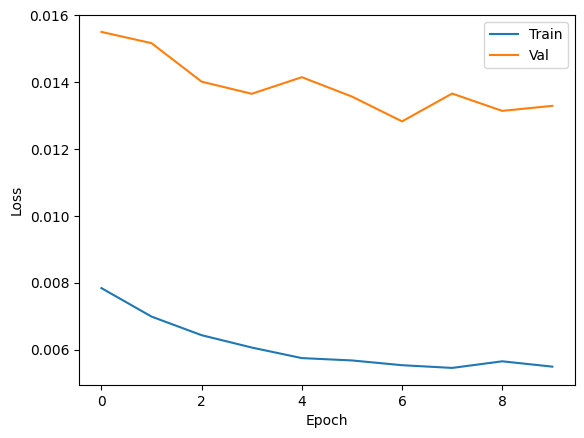

In [11]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
#ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()